### DATA CLEANING

In [128]:
import pandas as pd
import glob
import numpy as np
import geopy
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime
import matplotlib.dates as mdates
import seaborn as sns

path = "C:/Users/wynbu/Desktop/datatest/"
rainfall_files = glob.glob(path + "rainfall*.csv")
rainfall_files

rainfall_list = []

for filename in rainfall_files:
    df_rainfall = pd.read_csv(filename)
    rainfall_list.append(df_rainfall)
    
rainfall_list[1]
df_rainfall = pd.concat(rainfall_list, axis=0, ignore_index=True)
df_rainfall = df_rainfall.dropna()

In [129]:
temp_files = glob.glob(path + "temperature*.csv")
temp_files

temp_list = []

for filename in temp_files:
    df_temp = pd.read_csv(filename)
    temp_list.append(df_temp)
    
temp_list[1]
df_temp = pd.concat(temp_list, axis=0, ignore_index=True)
df_temp = df_temp.dropna()

In [130]:
df_temp.describe()
df_rainfall.describe()
# The temperature and rainfall data seem reasonable. There is no outlier.


,date,latitude,longitude,rainfall,year,month,day
count,5.642340e+05,564234.000000,564234.000000,564234.000000,564234.000000,564234.000000,564234.000000
mean,2.011067e+07,23.626214,79.435275,3.099526,2011.000548,6.523549,15.727820
std,1.414425e+04,6.028008,6.042655,10.610632,1.414021,3.448536,8.799332
min,2.009010e+07,8.500000,68.500000,0.000000,2009.000000,1.000000,1.000000
25%,2.010040e+07,19.500000,75.500000,0.000000,2010.000000,4.000000,8.000000
50%,2.011070e+07,24.500000,78.500000,0.000000,2011.000000,7.000000,16.000000
75%,2.012100e+07,27.500000,82.500000,0.400000,2012.000000,10.000000,23.000000
max,2.013123e+07,36.500000,96.500000,384.100000,2013.000000,12.000000,31.000000


In [131]:
#We do not need date in the following calculation, therefore, drop date.
df_rainfall = df_rainfall.drop(columns = 'date')
df_temp = df_temp.drop(columns = 'date')

In [132]:
df_district = pd.read_csv("district_crosswalk_small.csv")

#Create a new df with temperature and rainfall data combined
df_total_1 = pd.merge(df_temp,
                    df_rainfall, on = ['latitude','longitude','year','month','day'], how = 'outer')

df_total_1 = df_total_1.dropna().reset_index(drop = True)

df_total_1.head().reset_index(drop = True)

# Drop duplicates in the grid points before calculating the distance, because it will take forever to calculate the distance with a lot of grid points repeating themselves.
df_total_2 =df_total_1[['latitude','longitude']].drop_duplicates().reset_index(drop = True)
df_total_2


,latitude,longitude
0,10.5,76.5
1,10.5,77.5
2,10.5,78.5
3,10.5,79.5
4,11.5,75.5
...,...,...
304,8.5,77.5
305,9.5,76.5
306,9.5,77.5
307,9.5,78.5


In [133]:
df_test = pd.DataFrame()
district_name = []
distance_lst = []

for row_dist_temp in df_district.iterrows():
    for row_total_temp in df_total_2.iterrows():
        row_dist = row_dist_temp[1]
        row_total = row_total_temp[1]
        distance = geodesic(
            (row_total['latitude'], row_total['longitude']),
        (row_dist['centroid_latitude'], row_dist['centroid_longitude'])
        ).km
        if distance < 100:
            district_name.append(row_dist['distname_iaa'])
            distance_lst.append(distance)
            df_test = df_test.append(row_total)

df_test['distance_lst'] = distance_lst
df_test['district_name'] = district_name

df_test.head()

,latitude,longitude,distance_lst,district_name
108,22.5,71.5,84.786904,ahmedabad
109,22.5,72.5,39.272688,ahmedabad
131,23.5,72.5,83.098117,ahmedabad
89,21.5,70.5,71.653342,amreli
90,21.5,71.5,36.231362,amreli


In [134]:
#Merge the df of grid connections within 100km with the df of all the grid points and their rainfall/temperature data
df = pd.merge(df_test,
                    df_total_1, on = ['latitude','longitude'], how = 'inner')
df

,latitude,longitude,distance_lst,district_name,temperature,day,month,year,rainfall
0,22.5,71.5,84.786904,ahmedabad,21.22,1,1,2009,0.0
1,22.5,71.5,84.786904,ahmedabad,22.92,1,2,2009,0.0
2,22.5,71.5,84.786904,ahmedabad,28.63,1,3,2009,0.0
3,22.5,71.5,84.786904,ahmedabad,32.53,1,4,2009,0.0
4,22.5,71.5,84.786904,ahmedabad,32.46,1,5,2009,0.0
...,...,...,...,...,...,...,...,...,...
361540,25.5,73.5,23.537026,pali,34.43,31,5,2013,0.0
361541,25.5,73.5,23.537026,pali,25.84,31,7,2013,0.8
361542,25.5,73.5,23.537026,pali,27.08,31,8,2013,0.0
361543,25.5,73.5,23.537026,pali,23.76,31,10,2013,0.0


##### Assumption 1: The original rainfall data is the daily total rainfall. Daily average rainfall is the total rainfall divided by 24 hours. Daily average temperature is the origional temperature data.

In [135]:
df['rainfall_mean'] = df['rainfall']/24
df.head(20)

,latitude,longitude,distance_lst,district_name,temperature,day,month,year,rainfall,rainfall_mean
0,22.5,71.5,84.786904,ahmedabad,21.22,1,1,2009,0.0,0.000000
1,22.5,71.5,84.786904,ahmedabad,22.92,1,2,2009,0.0,0.000000
2,22.5,71.5,84.786904,ahmedabad,28.63,1,3,2009,0.0,0.000000
3,22.5,71.5,84.786904,ahmedabad,32.53,1,4,2009,0.0,0.000000
4,22.5,71.5,84.786904,ahmedabad,32.46,1,5,2009,0.0,0.000000
5,22.5,71.5,84.786904,ahmedabad,32.89,1,6,2009,0.0,0.000000
6,22.5,71.5,84.786904,ahmedabad,31.37,1,7,2009,0.0,0.000000
7,22.5,71.5,84.786904,ahmedabad,29.15,1,8,2009,0.5,0.020833
8,22.5,71.5,84.786904,ahmedabad,28.73,1,9,2009,0.9,0.037500
9,22.5,71.5,84.786904,ahmedabad,31.65,1,10,2009,0.0,0.000000


In [136]:
dist_count = df[['district_name', 'year']].value_counts().reset_index().rename(columns = {0: 'district_count'})

In [137]:
df = df.merge(dist_count, on = ['district_name', 'year'])
df.head()

,latitude,longitude,distance_lst,district_name,temperature,day,month,year,rainfall,rainfall_mean,district_count
0,22.5,71.5,84.786904,ahmedabad,21.22,1,1,2009,0.0,0.0,1095
1,22.5,71.5,84.786904,ahmedabad,22.92,1,2,2009,0.0,0.0,1095
2,22.5,71.5,84.786904,ahmedabad,28.63,1,3,2009,0.0,0.0,1095
3,22.5,71.5,84.786904,ahmedabad,32.53,1,4,2009,0.0,0.0,1095
4,22.5,71.5,84.786904,ahmedabad,32.46,1,5,2009,0.0,0.0,1095


In [138]:
weighted_mean_rain_lst = []
for row in df.iterrows():
    row = row[1]
    weighted_mean_rain = row['rainfall_mean']/(row['distance_lst']**2 * row['district_count'])
    weighted_mean_rain_lst += [weighted_mean_rain]
    
df['weighted_mean_rain'] = weighted_mean_rain_lst

weighted_total_rain_lst = []
for row in df.iterrows():
    row = row[1]
    weighted_total_rain = row['rainfall']/(row['distance_lst']**2 * row['district_count'])
    weighted_total_rain_lst += [weighted_total_rain]
    
df['weighted_total_rain'] = weighted_total_rain_lst    

weighted_mean_temp_lst = []
for row in df.iterrows():
    row = row[1]
    weighted_mean_temp = row['temperature']/(row['distance_lst']**2 * row['district_count'])
    weighted_mean_temp_lst += [weighted_mean_temp]
    
df['weighted_mean_temp'] = weighted_mean_temp_lst
df

,latitude,longitude,distance_lst,district_name,temperature,day,month,year,rainfall,rainfall_mean,district_count,weighted_mean_rain,weighted_total_rain,weighted_mean_temp
0,22.5,71.5,84.786904,ahmedabad,21.22,1,1,2009,0.0,0.000000,1095,0.000000e+00,0.000000,0.000003
1,22.5,71.5,84.786904,ahmedabad,22.92,1,2,2009,0.0,0.000000,1095,0.000000e+00,0.000000,0.000003
2,22.5,71.5,84.786904,ahmedabad,28.63,1,3,2009,0.0,0.000000,1095,0.000000e+00,0.000000,0.000004
3,22.5,71.5,84.786904,ahmedabad,32.53,1,4,2009,0.0,0.000000,1095,0.000000e+00,0.000000,0.000004
4,22.5,71.5,84.786904,ahmedabad,32.46,1,5,2009,0.0,0.000000,1095,0.000000e+00,0.000000,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361540,25.5,73.5,23.537026,pali,34.43,31,5,2013,0.0,0.000000,730,0.000000e+00,0.000000,0.000085
361541,25.5,73.5,23.537026,pali,25.84,31,7,2013,0.8,0.033333,730,8.242381e-08,0.000002,0.000064
361542,25.5,73.5,23.537026,pali,27.08,31,8,2013,0.0,0.000000,730,0.000000e+00,0.000000,0.000067
361543,25.5,73.5,23.537026,pali,23.76,31,10,2013,0.0,0.000000,730,0.000000e+00,0.000000,0.000059


In [175]:
df_new = df.groupby(['year','day','month','district_name'])[['weighted_mean_rain',
                                                      'weighted_total_rain',
                                                      'weighted_mean_temp']].sum().reset_index()
df_new.to_csv('Q2_dataset.csv')

My code could scale up with larger datasets. 

First, instead of importing dataset one by one, I used for loop to automatically retrieve datasets from folders. For larger datasets, as long as they have keywords such as "rainfall" in their names, they can be imported via for loop.

Second, I drop duplicates grid points before calculating their distances from district centers. This allows the computer to finish calculation in a much shorter time. For larger dataset, it is important to also drop those duplicates before computing the distances.

Third, we can also use ArcGis to map large numbers of grid points to districts shapefile.
For a dataset with 339 districts and 112 years，and a smaller grid, it will taker more computing power and longer time to finish calculation.

### DATA EXPLORATION

In [147]:
df_new['Datetime'] = pd.to_datetime( df_new[['year', 'month', 'day']])
df_new

df_new[df_new['district_name'] == 'jaipur']
# The naming in 1961 for jaipur is the same as mentioned in the test.

,year,day,month,district_name,weighted_mean_rain,weighted_total_rain,weighted_mean_temp,Datetime
30,2009,1,1,jaipur,0.000000e+00,0.000000,0.000008,2009-01-01
105,2009,1,2,jaipur,0.000000e+00,0.000000,0.000009,2009-02-01
180,2009,1,3,jaipur,0.000000e+00,0.000000,0.000012,2009-03-01
255,2009,1,4,jaipur,0.000000e+00,0.000000,0.000014,2009-04-01
330,2009,1,5,jaipur,0.000000e+00,0.000000,0.000018,2009-05-01
...,...,...,...,...,...,...,...,...
136605,2013,31,5,jaipur,0.000000e+00,0.000000,0.000018,2013-05-31
136680,2013,31,7,jaipur,6.828752e-08,0.000002,0.000015,2013-07-31
136755,2013,31,8,jaipur,0.000000e+00,0.000000,0.000015,2013-08-31
136830,2013,31,10,jaipur,0.000000e+00,0.000000,0.000013,2013-10-31


In [148]:
df_jaipur = df_new[(df_new['district_name'] == 'jaipur')]
df_jaipur

,year,day,month,district_name,weighted_mean_rain,weighted_total_rain,weighted_mean_temp,Datetime
30,2009,1,1,jaipur,0.000000e+00,0.000000,0.000008,2009-01-01
105,2009,1,2,jaipur,0.000000e+00,0.000000,0.000009,2009-02-01
180,2009,1,3,jaipur,0.000000e+00,0.000000,0.000012,2009-03-01
255,2009,1,4,jaipur,0.000000e+00,0.000000,0.000014,2009-04-01
330,2009,1,5,jaipur,0.000000e+00,0.000000,0.000018,2009-05-01
...,...,...,...,...,...,...,...,...
136605,2013,31,5,jaipur,0.000000e+00,0.000000,0.000018,2013-05-31
136680,2013,31,7,jaipur,6.828752e-08,0.000002,0.000015,2013-07-31
136755,2013,31,8,jaipur,0.000000e+00,0.000000,0.000015,2013-08-31
136830,2013,31,10,jaipur,0.000000e+00,0.000000,0.000013,2013-10-31


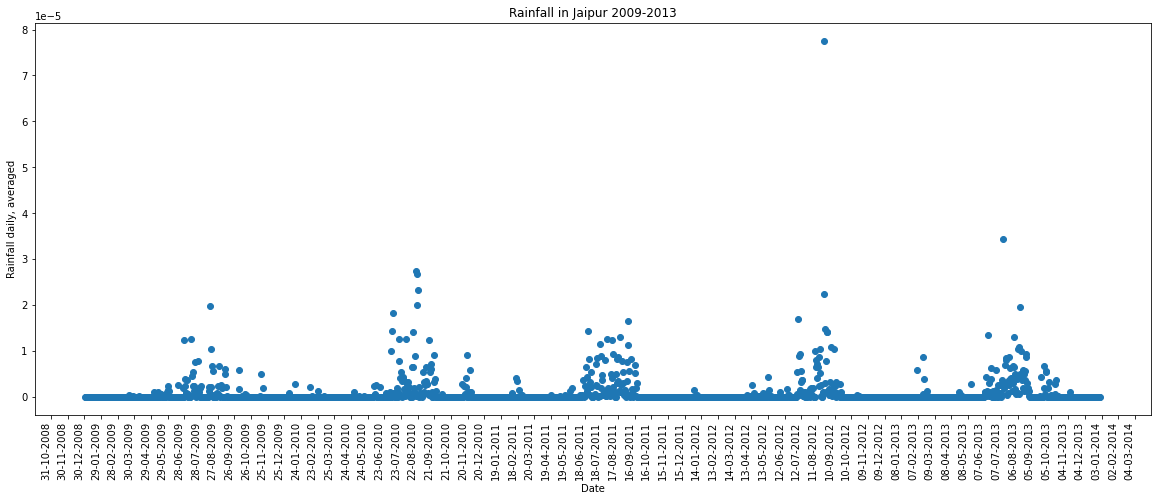

In [149]:
plt.figure(figsize=(20,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.scatter(df_jaipur.Datetime, df_jaipur.weighted_total_rain)

plt.xticks(rotation=90)

plt.title("Rainfall in Jaipur 2009-2013")
plt.ylabel("Rainfall daily, averaged")
plt.xlabel("Date")

plt.savefig('Rainfall in Jaipur 2009-2013.pdf')

# The monsoon season usually starts around 07/20 and ends aroung 09/20 every year.


In [150]:
df_state_1 = pd.merge(df_test,
                    df_total_1, on = ['latitude','longitude'], how = 'inner')
df_state_1

df_district. rename(columns = {'distname_iaa':'district_name'}, inplace = True)

df_state = pd.merge(df_district,
                    df_state_1, on = ['district_name'], how = 'inner')
df_state


,stname_iaa,district_name,stid_iaa,distid_iaa,centroid_longitude,centroid_latitude,unique_dist_id,latitude,longitude,distance_lst,temperature,day,month,year,rainfall
0,gujarat,ahmedabad,17,11,72.267197,22.781200,1711,22.5,71.5,84.786904,21.22,1,1,2009,0.0
1,gujarat,ahmedabad,17,11,72.267197,22.781200,1711,22.5,71.5,84.786904,22.92,1,2,2009,0.0
2,gujarat,ahmedabad,17,11,72.267197,22.781200,1711,22.5,71.5,84.786904,28.63,1,3,2009,0.0
3,gujarat,ahmedabad,17,11,72.267197,22.781200,1711,22.5,71.5,84.786904,32.53,1,4,2009,0.0
4,gujarat,ahmedabad,17,11,72.267197,22.781200,1711,22.5,71.5,84.786904,32.46,1,5,2009,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361540,rajasthan,udaipur,5,20,73.782799,24.616199,520,24.5,73.5,31.408182,33.63,31,5,2013,1.0
361541,rajasthan,udaipur,5,20,73.782799,24.616199,520,24.5,73.5,31.408182,25.14,31,7,2013,0.3
361542,rajasthan,udaipur,5,20,73.782799,24.616199,520,24.5,73.5,31.408182,27.05,31,8,2013,0.0
361543,rajasthan,udaipur,5,20,73.782799,24.616199,520,24.5,73.5,31.408182,23.61,31,10,2013,0.0


In [151]:
#table of annual average temperature by state and year. 
df_state_year = df_state.groupby(['stname_iaa', 'year'])['temperature'].mean().reset_index()
df_state_year.columns = ['State_name', 'Year','Yearly_mean_temperature']
df_state_year.describe()
df_state_year.head()


,State_name,Year,Yearly_mean_temperature
0,gujarat,2009,27.523286
1,gujarat,2010,27.473928
2,gujarat,2011,26.911344
3,gujarat,2012,26.611386
4,gujarat,2013,26.575315


In [152]:
print(df_state_year.to_latex(index=False)) 

\begin{tabular}{lrr}
\toprule
 State\_name &  Year &  Yearly\_mean\_temperature \\
\midrule
    gujarat &  2009 &                27.523286 \\
    gujarat &  2010 &                27.473928 \\
    gujarat &  2011 &                26.911344 \\
    gujarat &  2012 &                26.611386 \\
    gujarat &  2013 &                26.575315 \\
     kerala &  2009 &                25.762561 \\
     kerala &  2010 &                25.913075 \\
     kerala &  2011 &                25.534873 \\
     kerala &  2012 &                25.832216 \\
     kerala &  2013 &                25.789354 \\
pondicherry &  2009 &                27.869318 \\
pondicherry &  2010 &                27.801767 \\
pondicherry &  2011 &                27.494247 \\
pondicherry &  2012 &                27.870324 \\
pondicherry &  2013 &                27.747113 \\
     punjab &  2009 &                23.489998 \\
     punjab &  2010 &                23.589237 \\
     punjab &  2011 &                22.879890 \\
     pun

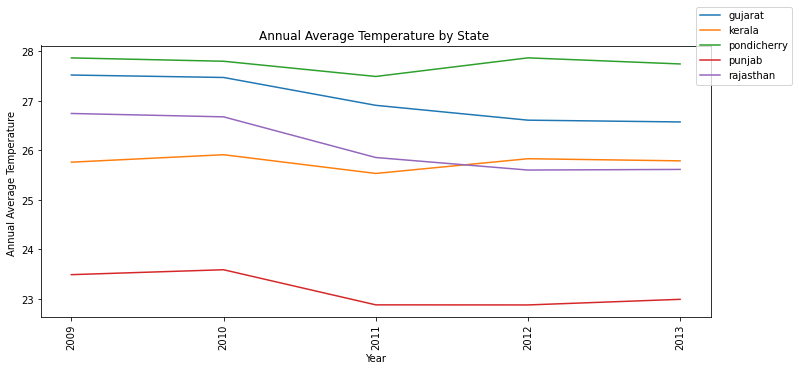

In [174]:
#graph of annual average temperature by state and year. 
df_state_year['Year'] = df_state_year['Year'].astype(str)

plt.figure(figsize=(12,5))

sns.lineplot(x='Year', y='Yearly_mean_temperature', data=df_state_year, hue='State_name')
plt.legend(bbox_to_anchor=(1.05, 1), loc='center')


plt.title("Annual Average Temperature by State ")
plt.ylabel("Annual Average Temperature ")
plt.xlabel("Year")

plt.xticks(rotation=90)


plt.savefig('Annual Average Temperature by State.pdf')
plt.show()